In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import h5py
import sys
import logging

import requests
from tqdm import tqdm_notebook
tqdm = tqdm_notebook

import numpy as np
import pandas as pd

from dvidutils import LabelMapper
from libdvid import DVIDNodeService

from neuclease import configure_default_logging
from neuclease.util.util import drop_unordered_duplicates
from neuclease.dvid import *
from neuclease.focused.ingest import fetch_focused_decisions, drop_previously_reviewed, load_focused_table
from neuclease.merge_table import (normalize_recarray_inplace, load_all_supervoxel_sizes, compute_body_sizes,
                                   generate_focused_assignment, generate_assignments)
from neuclease.merge_graph import LabelmapMergeGraph

In [3]:
from neuclease.dvid.labelmap._split import *
from neuclease.dvid.labelmap._labelmap import *

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
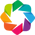

In [84]:
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

In [4]:
configure_default_logging()

In [5]:
pwd

'/nrs/flyem/bergs/complete-ffn-agglo'

### UUIDs

In [9]:
server = 'emdata2:7900'

# analysis_node = (server, '662e')
# analysis_seg = analysis_node + ('segmentation',)

#master_uuid = find_branch_nodes(server, 'a77', branch="")[-1]

# Use slightly out-of-date uuid
master_uuid = '9e0d'


master_node = (server, master_uuid)
master_seg = master_node + ('segmentation',)
print(f"Working with current master UUID: {master_uuid}")

Working with current master UUID: 9e0d


### Mapping

In [10]:
#analysis_mapping = fetch_complete_mappings(*analysis_seg)
#analysis_mapper = LabelMapper(analysis_mapping.index.values, analysis_mapping.values)

In [11]:
master_mapping = fetch_complete_mappings(*master_seg)
master_mapper = LabelMapper(master_mapping.index.values, master_mapping.values)

INFO [2018-09-13 13:38:30,770] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata2:7900 / 9e0d / segmentation
INFO [2018-09-13 13:39:03,612] Reading 912966 kafka messages took 32.840585231781006 seconds
INFO [2018-09-13 13:39:12,549] Fetching http://emdata2:7900/api/node/9e0d/segmentation/mappings...
INFO [2018-09-13 13:39:39,865] Fetching http://emdata2:7900/api/node/9e0d/segmentation/mappings took 0:00:27.315191
INFO [2018-09-13 13:39:39,866] Parsing mapping...
INFO [2018-09-13 13:39:46,705] Parsing mapping took 0:00:06.838485
INFO [2018-09-13 13:39:46,708] Constructing missing identity-mappings...
INFO [2018-09-13 13:40:08,024] Constructing missing identity-mappings took 0:00:21.314726


### Important bodies

In [12]:
#body_synapse_stats_path = 'focused-7254-2tbars-2psds-10.0Mv.npy'

##
## Using Master node state!
##

body_synapse_stats_path = f'focused-{master_uuid}-2tbars-2psds-10.0Mv.npy'
body_synapse_stats = pd.DataFrame(np.load(body_synapse_stats_path))
body_synapse_stats.set_index('body', inplace=True)

# Filter for 0.5 criteria
focused_bodies_table = body_synapse_stats.query('PreSyn >= 2 or PostSyn >= 10 or voxel_count >= 10e6')

important_bodies = set(focused_bodies_table.index)
print(f"Working with {len(important_bodies)} focused bodies")

Working with 535639 focused bodies


### Load body sizes (from master node)

In [14]:
copyseg_jobs_dir = '/groups/flyem/data/scratchspace/copyseg-configs/labelmaps/hemibrain/8nm/'
root_sv_sizes = f'{copyseg_jobs_dir}/compute-8nm-extended-fixed-STATS-ONLY-20180402.192015/supervoxel-sizes.h5'

sv_sizes = load_all_supervoxel_sizes(*master_seg, root_sv_sizes)
master_body_stats = compute_body_sizes(sv_sizes, master_mapping, True)

INFO [2018-09-13 13:41:14,399] Volume contains 188243164 supervoxels and 22.5 Teravoxels in total
INFO [2018-09-13 13:41:14,616] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata2:7900 / 9e0d / segmentation
INFO [2018-09-13 13:41:47,840] Reading 912966 kafka messages took 33.22228956222534 seconds
INFO [2018-09-13 13:41:57,221] Fetching sizes for 7314 split supervoxels...
INFO [2018-09-13 13:42:23,539] Fetching sizes for 7314 split supervoxels took 0:00:26.317415
INFO [2018-09-13 13:43:11,973] Dropping unknown supervoxels
INFO [2018-09-13 13:43:47,185] Applying sizes to mapping
INFO [2018-09-13 13:44:18,153] Aggregating sizes by body
INFO [2018-09-13 13:44:29,982] Appending singleton sizes
INFO [2018-09-13 13:46:13,297] Sorting sizes


### Load set of bad supervoxels

In [ ]:
sv_classifications = '/nrs/flyem/bergs/sv-classifications.h5'
with h5py.File(sv_classifications, 'r') as f:
    sv_classes = pd.DataFrame({'sv': f['supervoxel_ids'][:],
                               'klass': f['classifications'][:].astype(np.uint8)})

    # Get the set of bad supervoxels
    all_class_names = list(map(bytes.decode, f['class_names'][:]))

bad_class_names = ['unknown', 'blood vessels', 'broken white tissue', 'glia', 'oob']
_bad_class_ids = set(map(all_class_names.index, bad_class_names))
bad_svs = sv_classes.query('klass in @_bad_class_ids')['sv']
bad_svs = pd.UInt64Index(bad_svs)

In [ ]:
print(f"Bad supervoxels: {len(bad_svs)/1e6:.1f}M")

bad_sv_sizes = pd.DataFrame(index=bad_svs).merge(pd.DataFrame(sv_sizes),
                                                 how='left', left_index=True, right_index=True)
bad_sv_sizes['body'] = master_mapper.apply(bad_sv_sizes.index.values, True)

# For bodies that contain at least one bad supervoxel,
# compute the total size of the bad supervoxels they contain
body_bad_voxels = bad_sv_sizes.groupby('body').agg({'voxel_count': 'sum'})

In [89]:
# Append total body size for comparison
body_bad_voxels = body_bad_voxels.merge(master_body_stats[['voxel_count']],
                                        how='left', left_index=True, right_index=True,
                                        suffixes=('_bad', '_total'))

bad_bodies = body_bad_voxels.query('voxel_count_bad > voxel_count_total//2').index

In [90]:
print(f"Bad bodies: {len(bad_bodies)}")

Bad bodies: 22551389


In [101]:
marked_bad_bodies = pd.read_csv('/nrs/flyem/bergs/complete-ffn-agglo/bad-bodies-2018-08-21.csv', dtype=np.uint64)['body']
all_bad_bodies = bad_bodies.union(marked_bad_bodies).sort_values()

### Fetch previous decisions (from MASTER)

In [17]:
previous_focused_decisions = fetch_focused_decisions(*master_node, 'segmentation_merged',
                                                     normalize_pairs='sv')

# Body info is nearly useless because they correspond to the body ID
# at the time the edge was assigned -- not the current body ID.
# Let's delete the body columns to ensure we don't accidentally try to use it for anything.
del previous_focused_decisions['body_a']
del previous_focused_decisions['body_b']

previous_focused_decisions.rename(inplace=True, columns={'sv_a': 'id_a', 'sv_b': 'id_b'})

# TODO: To properly handle split IDs,
#       Consider reverse-mapping these supervoxel IDs back to their IDs in the analysis node.

In [18]:
assert previous_focused_decisions.eval('id_a <= id_b').all()
print(f"Loaded {len(previous_focused_decisions)} previous decisions")

Loaded 532377 previous decisions


### Load it1 and it2 only

In [19]:
d = 'speculative-iterations'
it1_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy'
it2_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase2_min0.1.npy'

it1_table = np.load(it1_path)
it2_table = np.load(it2_path)

print(f"it1: {it1_table.shape}")
print(f"it2: {it2_table.shape}")

merge_table = np.concatenate( (it1_table, it2_table) )
normalize_recarray_inplace(merge_table, 'id_a', 'id_b',
                           ['id_a', 'xa', 'ya', 'za'],
                           ['id_b', 'xb', 'yb', 'zb'])

merge_table_df = pd.DataFrame(merge_table)
del it1_table
del it2_table
del merge_table

print(f"Loaded combined table: {merge_table_df.shape}")
merge_table_df.head(3)

it1: (75446740,)
it2: (10302249,)
Loaded combined table: (85748989, 9)


id_a       id_b     xa     ya    za     xb     yb    zb  score
0  109025907  140060777  23837  20286  1763  23834  20302  1776   13.0
1  109025907  109025923  23837  20286  1763  23841  20291  1766   13.0
2  109707975  110049207  23955  21390  1669  23954  21396  1672   13.0

### It 1 only

In [20]:
# d = 'speculative-iterations'
# it1_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase1_min0.1.npy'
# #it2_path = f'{d}/final_20180312_32nm_16nm_all_cbs32_upto10_cb16_upto10_freeze_all_spec_phase2_min0.1.npy'

# it1_table = np.load(it1_path)
# #it2_table = np.load(it2_path)

# print(f"it1: {it1_table.shape}")
# #print(f"it2: {it2_table.shape}")

# #merge_table = np.concatenate( (it1_table, it2_table) )
# merge_table = it1_table
# normalize_recarray_inplace(merge_table, 'id_a', 'id_b',
#                            ['id_a', 'xa', 'ya', 'za'],
#                            ['id_b', 'xb', 'yb', 'zb'])

# merge_table_df = pd.DataFrame(merge_table)
# del it1_table
# #del it2_table
# del merge_table

# print(f"Loaded combined table: {merge_table_df.shape}")
# merge_table_df.head(3)

### Replace Split SVs

In [21]:
merge_graph = LabelmapMergeGraph(merge_table_df)
merge_graph.append_edges_for_split_supervoxels(master_seg, parent_sv_handling='drop')
merge_table_df = merge_graph.merge_table_df

INFO [2018-09-13 13:50:04,068] Reading kafka messages from ['kafka.int.janelia.org:9092', 'kafka2.int.janelia.org:9092', 'kafka3.int.janelia.org:9092'] for emdata2:7900 / 9e0d / segmentation
INFO [2018-09-13 13:50:39,639] Reading 912970 kafka messages took 35.57105994224548 seconds
INFO [2018-09-13 13:52:09,406] Appending 65318 edges with split supervoxel IDs...
INFO [2018-09-13 13:52:09,411] Fetching supervoxels from split edge coordinates...
INFO [2018-09-13 13:57:16,097] Fetching supervoxels from split edge coordinates took 0:05:06.684805
INFO [2018-09-13 13:58:34,181] Appending 65318 edges with split supervoxel IDs took 0:06:24.771521


#### backup

In [22]:
unfiltered_merge_table_df = merge_table_df.copy()

In [23]:
# Restore from backup
#merge_table_df = unfiltered_merge_table_df.copy()

### Drop 'dontMerge' decisions

In [24]:
orig_len = len(merge_table_df)
bad_edges = previous_focused_decisions.query('result == "dontMerge"')
merge_table_df = drop_previously_reviewed(merge_table_df, bad_edges)
merge_table_df = merge_table_df.copy()

dropped = orig_len - len(merge_table_df)
print(f"Dropped {dropped} edges, kept {len(merge_table_df)}")

Dropped 47064 edges, kept 85701754


In [25]:
merge_table_df = merge_table_df.copy()

### Apply mapping

In [32]:
merge_table_df['body_a'] = master_mapper.apply(merge_table_df['id_a'].values, True)
merge_table_df['body_b'] = master_mapper.apply(merge_table_df['id_b'].values, True)

#### Drop unmapped bodies (due to uncorrected splits)

In [33]:
orig_len = len(merge_table_df)
merge_table_df.query('body_a != 0 and body_b != 0', inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}")

Dropped 109


#### Drop bad bodies

In [105]:
merge_table_df.query('body_a not in @all_bad_bodies and body_b not in @all_bad_bodies', inplace=True)

### Filter internal edges

In [106]:
orig_len = len(merge_table_df)
merge_table_df.query('body_a != body_b', inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}")

Dropped 0


### Append importances

In [107]:
merge_table_df['important_a'] = merge_table_df.eval('body_a in @important_bodies')
merge_table_df['important_b'] = merge_table_df.eval('body_b in @important_bodies')

### Filter: Drop edges that are non-adjacent to important bodies (leave 1/2-hop only)

In [108]:
%%time
orig_len = len(merge_table_df)
merge_table_df.query('important_a or important_b', inplace=True)
print(f"Dropped {orig_len - len(merge_table_df)}, kept {len(merge_table_df)}")

Dropped 0, kept 210024
CPU times: user 130 ms, sys: 26.3 ms, total: 156 ms
Wall time: 9.6 ms


### Drop duplicate body pairings

In [109]:
### In case of duplicate body pairs, drop higher (worse) score
orig_size = len(merge_table_df)
merge_table_df = merge_table_df.copy()
merge_table_df.sort_values('score', inplace=True)
merge_table_df = drop_unordered_duplicates(merge_table_df, ['body_a', 'body_b'])
merge_table_df.shape
print(f"Dropped {orig_size - len(merge_table_df)}, kept {len(merge_table_df)}")

Dropped 0, kept 210024


### Drop "dangling" edges

In [110]:
def compute_body_counts(df):
    # Every non-important body must be present in at least two edges
    body_counts_a = df['body_a'].value_counts()
    body_counts_b = df['body_b'].value_counts()

    body_counts_a, body_counts_b = body_counts_a.align(body_counts_b, fill_value=0)
    body_counts = body_counts_a + body_counts_b

    return body_counts

def drop_dangling_edges_inplace(df):
    body_counts = compute_body_counts(df)
    dangling_bodies = set(body_counts[body_counts < 2].index)
    
    orig_len = len(df)
    q = '(important_a or (body_a not in @dangling_bodies)) and (important_b or (body_b not in @dangling_bodies))'
    df.query(q, inplace=True)
    print(f"Dropped {orig_len - len(df)}, kept {len(df)}")

In [111]:
drop_dangling_edges_inplace(merge_table_df)

Dropped 0, kept 210024


In [112]:
merge_table_df.head()

id_a        id_b     xa     ya     za     xb     yb     zb  \
1302004  1842651106  1842651107  34136  14642  25756  34144  14642  25756   
84950     480975497   481316536  10521  20101   6891  10544  20089   6914   
13138     299764489   300105384  33522  26189   4063  33515  26195   4056   
14370     301802135   301802136  32711  28426   4388  32716  28430   4388   
49082     395256528   426290995  33384  29190   5694  33390  29195   5700   

         score      body_a      body_b  important_a  important_b  
1302004   13.0  1811612764  1842651107         True        False  
84950     13.0   479948037   481316536         True        False  
13138     13.0   268385667   300105384         True        False  
14370     13.0   301802135   301460882        False         True  
49082     13.0   395256528   301128380        False         True

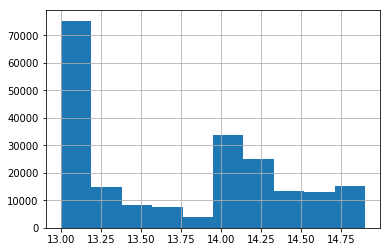

In [113]:
merge_table_df['score'].hist()

### Drop all previously reviewed

In [114]:
unreviewed_it2_twohop_df = drop_previously_reviewed(merge_table_df, previous_focused_decisions)
num_twohop_edges = len(unreviewed_it2_twohop_df)
num_twohop_bodies = len(pd.unique(unreviewed_it2_twohop_df[['body_a', 'body_b']].values.reshape(-1)))
print(f"Found {num_twohop_edges / 1e6:.2f}M edges, touching {num_twohop_bodies/1e6:.2f}M bodies")

Found 0.19M edges, touching 0.24M bodies


#### How many are 1-hop edges that we've missed so far?

In [115]:
# (we missed these due to previously incomplete focused list)
it2_onehop_df = unreviewed_it2_twohop_df.query('body_a in @important_bodies and body_b in @important_bodies')
print(f"Found {len(it2_onehop_df)} new 1-hop edges")
it2_onehop_df.to_csv('it2-onehop.csv', header=True, index=False)

Found 18684 new 1-hop edges


#### it2 one-hop assignments

In [116]:
#it2_onehop_df = load_focused_table('it2-onehop.csv')
#it2_onehop_df.shape

In [117]:
#it2_onehop_df.sort_values('score', inplace=True)
#it2_onehop_df = drop_unordered_duplicates(it2_onehop_df, ['body_a', 'body_b'])
#it2_onehop_df.shape

In [118]:
#np.random.seed(0)
#shuffled_index = np.array(it2_onehop_df.index)
#np.random.shuffle(shuffled_index)
#shuffled_it2_onehop_df = it2_onehop_df.loc[shuffled_index]

In [119]:
#generate_assignments(shuffled_it2_onehop_df, 5000, 'it2-onehop-assignments')

#### (it1 only)

In [120]:
# unreviewed_it1_twohop_df = drop_previously_reviewed(master_merge_table_df, previous_focused_decisions)
# num_twohop_edges = len(unreviewed_it1_twohop_df)
# num_twohop_bodies = len(pd.unique(unreviewed_it1_twohop_df[['body_a', 'body_b']].values.reshape(-1)))
# print(f"Found {num_twohop_edges / 1e6:.2f}M edges, touching {num_twohop_bodies/1e6:.2f}M bodies")

### Select it1 or it2

In [121]:
#unreviewed_twohop_df = unreviewed_it1_twohop_df.copy()
unreviewed_twohop_df = unreviewed_it2_twohop_df.copy()
unreviewed_twohop_df.shape

(192623, 13)

#### Drop duplicate body pairings

In [122]:
### In case of duplicate body pairs, drop higher (worse) score
orig_len = len(unreviewed_twohop_df)
unreviewed_twohop_df = unreviewed_twohop_df.copy()
unreviewed_twohop_df.sort_values('score', inplace=True)
unreviewed_twohop_df = drop_unordered_duplicates(unreviewed_twohop_df, ['body_a', 'body_b'])
print(f"Dropped {orig_len - len(unreviewed_twohop_df)}")

Dropped 0


### Append body sizes (from master)

In [123]:
unreviewed_twohop_df.drop(columns=['voxel_count_a', 'voxel_count_b', 'voxel_count', 'voxel_count_x', 'voxel_count_y'],
                          errors='ignore', inplace=True)
unreviewed_twohop_df = unreviewed_twohop_df.merge( master_body_stats[['voxel_count']],
                                                   how='left', left_on='body_a', right_index=True)
unreviewed_twohop_df = unreviewed_twohop_df.merge( master_body_stats[['voxel_count']],
                                                   how='left', left_on='body_b', right_index=True,
                                                   suffixes=['_a', '_b'])
unreviewed_twohop_df.shape

(192623, 15)

In [124]:
unreviewed_twohop_df.head(3)

id_a        id_b     xa     ya     za     xb     yb     zb  \
1302004  1842651106  1842651107  34136  14642  25756  34144  14642  25756   
1260081  1808772218  1808772219  22274  11357  25634  22284  11366  25634   
1304350  1843852159  1843852166  17904  16280  26146  17906  16283  26148   

         score      body_a      body_b  important_a  important_b  \
1302004   13.0  1811612764  1842651107         True        False   
1260081   13.0  1160466122  1808772219         True        False   
1304350   13.0  1312826146  1843852166         True        False   

         voxel_count_a  voxel_count_b  
1302004        8797196              8  
1260081      817554560              7  
1304350     1590543876             19

#### Drop 1-hop

In [125]:
unreviewed_twohop_df.query('important_a != important_b', inplace=True)
unreviewed_twohop_df.shape

(173939, 15)

In [126]:
# Drop dangling AGAIN
drop_dangling_edges_inplace(unreviewed_twohop_df)

Dropped 7, kept 173932


#### Append columns for important/unimportant (instead of a/b)

In [127]:
important_b = unreviewed_twohop_df['important_b']

# Init with body A values
unreviewed_twohop_df['body_i'] = unreviewed_twohop_df['body_a'].copy()
unreviewed_twohop_df['body_u'] = unreviewed_twohop_df['body_a'].copy()

# Replace where body B is important/unimportant
unreviewed_twohop_df.loc[important_b, 'body_i'] = unreviewed_twohop_df.loc[important_b, 'body_b']
unreviewed_twohop_df.loc[~important_b, 'body_u'] = unreviewed_twohop_df.loc[~important_b, 'body_b']

# Init with body A values
unreviewed_twohop_df['voxel_count_i'] = unreviewed_twohop_df['voxel_count_a'].copy()
unreviewed_twohop_df['voxel_count_u'] = unreviewed_twohop_df['voxel_count_a'].copy()

# Replace where body B is important/unimportant
unreviewed_twohop_df.loc[important_b, 'voxel_count_i'] = unreviewed_twohop_df.loc[important_b, 'voxel_count_b']
unreviewed_twohop_df.loc[~important_b, 'voxel_count_u'] = unreviewed_twohop_df.loc[~important_b, 'voxel_count_b']

#### Sort by descending UN-important size

In [128]:
unreviewed_twohop_df.sort_values(['voxel_count_u', 'body_u', 'voxel_count_i'], ascending=False, inplace=True)

In [129]:
#bc = unreviewed_twohop_df['body_u'].value_counts()
#bc.head()

In [130]:
unreviewed_twohop_df.head()

id_a        id_b     xa     ya     za     xb     yb     zb  \
81807283  1656523739  1656523773   8012  15322  23324   8004  15452  23388   
81994728  1624798369  1656523739   7990  15428  23336   7998  15316  23320   
75493776  2564073687  2564073734  11578  24910  35944  11616  24820  36016   
3742148   2563733153  2594767518  11808  24274  36438  11770  24260  36474   
74112751  2005354660  2005691292   2560  24652  28436   2618  24564  28456   

              score      body_a      body_b  important_a  important_b  \
81807283  14.680614  1656523739  1656523773        False         True   
81994728  14.697225  1624457220  1656523739         True        False   
75493776  14.010571  2380601668  2563733153         True        False   
3742148   13.008522  2563733153  2594426671        False         True   
74112751  13.886168  2005009795   821345327        False         True   

          voxel_count_a  voxel_count_b      body_i      body_u  voxel_count_i  \
81807283        9994467       20444141  1656523773  1656523739       20444141   
81994728       10324326        9994467  1624457220  1656523739       10324326   
75493776      322378429        9962644  2380601668  2563733153      322378429   
3742148         9962644       72127708  2594426671  2563733153       72127708   
74112751        9954307     1098184075   821345327  2005009795     1098184075   

          voxel_count_u  
81807283        9994467  
81994728        9994467  
75493776        9962644  
3742148         9962644  
74112751        9954307

In [131]:
unreviewed_twohop_df['voxel_count_u'].reset_index(drop=True).hvplot(kind='line')

:Curve   [index]   (voxel_count_u)

In [168]:
unreviewed_twohop_df['body_u'].value_counts(sort=True).reset_index(drop=True).hvplot(kind='line')

:Curve   [index]   (body_u)

In [179]:
unreviewed_twohop_df['body_i'].value_counts(sort=True).reset_index(drop=True).hvplot(kind='line')

:Curve   [index]   (body_i)

In [160]:
twohop_important_bodies = pd.unique(unreviewed_twohop_df['body_i'])
twohop_unimportant_bodies = pd.unique(unreviewed_twohop_df['body_u'])
num_important_bodies = len(twohop_important_bodies)
num_unimportant_bodies = len(twohop_unimportant_bodies)

print(f"Total edges: {len(unreviewed_twohop_df)/1000:.1f}k")
print(f"Important bodies: {num_important_bodies/1000:.1f}k")
print(f"Unimportant bodies: {num_unimportant_bodies/1000:.1f}k")

Total edges: 173.9k
Important bodies: 130.5k
Unimportant bodies: 86.4k


In [156]:
from neuclease.util import connected_components
def connected_components_nonconsecutive(edges, node_ids):
    assert node_ids.ndim == 1
    assert node_ids.dtype in (np.uint32, np.uint64)
    cons_node_ids = np.arange(len(node_ids), dtype=np.uint32)
    mapper = LabelMapper(node_ids, cons_node_ids)
    cons_edges = mapper.apply(edges)
    return connected_components(cons_edges, len(node_ids))

In [159]:
_body_edges = unreviewed_twohop_df[['body_a', 'body_b']].values
_bodies = pd.unique(_body_edges.flat)
cc = connected_components_nonconsecutive(_body_edges, _bodies)
num_cc = len(pd.unique(cc))
print(f"Num CC: {num_cc}, i.e. {num_important_bodies - num_cc} bodies eliminated")

Num CC: 43207, i.e. 87292 bodies eliminated


### Generate test assignment

In [176]:
from neuclease.bin.adjust_focused_points import adjust_focused_points

# Select subset of intermediate (unimportant) bodies, and choose all edges for those bodies
np.random.seed(999)
selected_bodies = set(np.random.choice(twohop_unimportant_bodies, 50, replace=False))
selected_twohop_df = unreviewed_twohop_df.query('body_u in @selected_bodies')

assignment_dir = 'it2-twohop-assignments'
os.makedirs(assignment_dir, exist_ok=True)
test_assignment_path = f'{assignment_dir}/test-assignment.json'

test_assignment = generate_focused_assignment(selected_twohop_df)
adjusted_assignment = adjust_focused_points(*master_seg, test_assignment)
with open(test_assignment_path, 'w') as f:
    json.dump(adjusted_assignment, f, indent=2)

HBox(children=(IntProgress(value=0), HTML(value='')))

### Analyze test results

In [183]:
test_results_df = fetch_focused_decisions('emdata3:8900', '0716', 'segmentation_merged',
                                          subset_pairs=selected_twohop_df[['id_a', 'id_b']].values)

In [191]:
selected_twohop_results_df = selected_twohop_df.merge(test_results_df[['sv_a', 'sv_b', 'result']],
                                                      how='left',
                                                      left_on=['id_a', 'id_b'],
                                                      right_on=['sv_a', 'sv_b'])
selected_twohop_results_df.shape

(100, 22)

In [207]:
path_results = selected_twohop_results_df.groupby('body_u').agg({'voxel_count_u': 'first',
                                                                 'score': ['max', 'min'],
                                                                 'result': lambda s: (s != 'dontMerge').all()})
#path_results.rename(columns={'result': 'both_merged'})
#print(f"Surviving paths: {path_results['result'].sum()}")
path_results.columns = ['voxel_count_u', 'score_max', 'score_min', 'result']
#path_results.sort_values('voxel_count_u', ascending=False)
path_results

voxel_count_u  score_max  score_min  result
body_u                                                 
330587508           20732  14.054697  13.039707   False
612159542            9664  14.050362  13.037193   False
635179104          443682  14.038013  13.023232   False
769389377           23759  14.164460  13.127000   False
801974474           40516  14.449428  14.056620   False
820743869           46636  13.093923  13.011049   False
892604648            4142  14.788984  13.630377   False
954229993            3859  14.817024  13.711046   False
1204508359          11712  14.655195  13.555373   False
1233532465          20401  14.120966  13.078243   False
1318032154          10447  14.818639  13.015343   False
1326817386          39084  14.162495  13.090815   False
1358866896           5955  14.200859  13.167601   False
1387976518              4  14.027209  13.018400   False
1409506252           3946  14.626346  13.044462   False
1438184180          20050  14.090591  13.137554   False
1452131049           3509  14.727839  13.628366   False
1474283073          29223  13.690858  13.545712   False
1544450201           2694  14.675370  13.208885   False
1590642016          41641  14.284785  13.152081   False
1625412126          69986  14.791834  13.213431   False
1628991008           6630  13.126769  13.003836   False
1632258940           4172  14.206102  13.133630    True
1655251006          61885  13.869523  13.630661   False
1724029300           4864  14.302302  13.272793   False
1726676062         359424  13.023723  13.016887   False
1755270851          11875  14.626865  13.525228   False
1776170065          13898  14.377151  13.206165    True
1787333451          11143  14.565966  13.416468   False
1809968314         488459  14.751012  13.219325   False
1823337424          62157  14.049830  13.041275   False
1848920555          81533  14.793635  13.101007   False
1854579169          13179  13.061612  13.032328    True
1858330862          39095  13.221795  13.207738   False
1902645361         755240  14.171203  14.051593   False
1909245545          23256  14.859945  14.854029   False
1933386928          10794  14.045362  13.037107   False
1941218411           1284  14.018141  13.008162   False
1949565926            317  14.079720  14.023964   False
1964278850           5619  14.340261  13.121070   False
2120799801          15976  13.017617  13.004507    True
2212562726         177198  14.177455  13.052453   False
2280606782          27055  14.252765  13.179405   False
2292357591           2593  14.555421  13.314672   False
2339624856         145263  14.086933  13.045609   False
2349898743          31266  14.797619  13.769792   False
2366178410           2153  14.234842  13.042506   False
2372658244           4765  14.104095  13.082234   False
2490136509          43547  14.657940  13.021136   False
2645993293          21875  14.151899  13.131974   False

result
dontMerge       63
merge           33
mergeLater       4

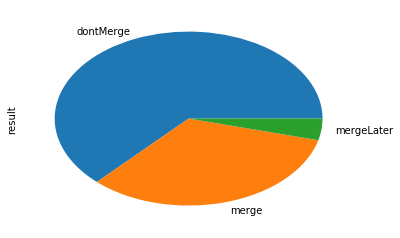

In [189]:
test_counts = test_results_df['result'].value_counts()
display(pd.DataFrame(test_counts))
test_counts.plot(kind='pie')

In [209]:
#test_results_df